# Evaluation

Using the results from the Markov chain Monte Carlo simulations as ground truth, we can evaluate the different methods to estimate the posterior distribution of the retrieval.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib_settings
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "/home/simonpf/src/keras/")
from keras.models import load_model

Using Theano backend.


In [2]:
from atms import load_file
root_group, v_y_true, v_cwv_true, v_cwv, v_h2o = load_file("mcmc_retrievals_5_5000.nc")

## The QRNN Models


TODO: Figure out smart way to store normalization results.

In [3]:
model = load_model("qrnn.h5", custom_objects={"<lambda>":"mean_absolute_error"})
model_1_32 = load_model("qrnn_1_32.h5", custom_objects={"<lambda>":"mean_absolute_error"})
model_2_32 = load_model("qrnn_2_32.h5", custom_objects={"<lambda>":"mean_absolute_error"})
model_2_64 = load_model("qrnn_2_64.h5", custom_objects={"<lambda>":"mean_absolute_error"})
model_2_128 = load_model("qrnn_2_128.h5", custom_objects={"<lambda>":"mean_absolute_error"})
model_3_128 = load_model("qrnn_3_128.h5", custom_objects={"<lambda>":"mean_absolute_error"})
model_opt = load_model("model_opt.h5", custom_objects={"<lambda>":"mean_absolute_error"})

x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_mean = np.mean(x_train, axis=0, keepdims=True)
x_sigma = np.std(x_train,axis=0, keepdims=True)
n = x_mean.shape[1]
(x_mean, np.mean(v_y_true, axis=0))

(array([[ 139.05841525,  175.31554085,  259.54564945,  273.19478918,
          263.9710617 ]]),
 array([ 139.11552094,  175.35268686,  259.48281244,  273.02020039,
         263.93371097]))

## CDF Fitting



In [4]:
import scipy as sc

taus = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95])

def make_pdf(taus, percs):
    y = np.zeros(taus.size + 2)
    y[1:-1] = taus
    y[0] = 0.0
    y[-1] = 1.0
    
    x = np.zeros(taus.size + 2)
    x[1:-1] = percs
    x[0]  = x[1] - (x[2] - x[1])
    x[-1] = x[-2] + (x[-2] - x[-3])
    
    print(x)
    print(y)
    tck = sc.interpolate.splrep(x, y)
    
    def pdf(xx):
        yy = 0.0 * xx
        inds_out_l = (xx < x[0])
        inds_out_r = (xx > x[-1])
        inds_in  = np.logical_not(inds_out_l + inds_out_r)
        yy[inds_out_l] = 0.0
        yy[inds_in] = sc.interpolate.splev(xx, tck, der = 0)[inds_in]
        yy[inds_out_r] = 1.0
        return yy
    
    return pdf


[ 26.03442383  26.31311607  26.59180832  26.81933212  26.93799973
  27.082304    27.13520241  27.21138573  27.37181282  27.54766464
  27.68869019  28.07973099  28.47077179]
[ 0.    0.05  0.15  0.25  0.35  0.45  0.5   0.55  0.65  0.75  0.85  0.95
  1.  ]


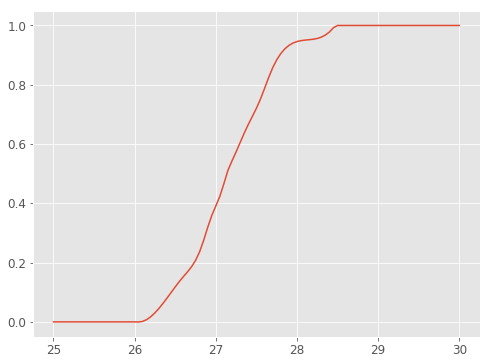

In [5]:
i = 10
x_test = (v_y_true[i].reshape(1,-1) - x_mean) / x_sigma
pred = model.predict(x_test)
f = make_pdf(taus, pred)

x = np.linspace(25, 30, 101)
plt.plot(x, f(x))

## Example Distributions

While looking at single test cases is not very conclusive, it is nice to get a feeling of the workings of the different methods.

[ 125.60686493  126.49526978  127.38367462  127.96599579  128.37854004
  128.81045532  128.99697876  129.14958191  129.57727051  130.00791931
  130.55641174  131.54718018  132.53794861]
[ 0.    0.05  0.15  0.25  0.35  0.45  0.5   0.55  0.65  0.75  0.85  0.95
  1.  ]


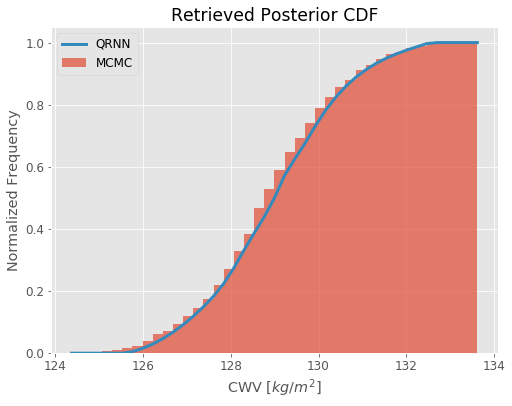

In [18]:
taus2 = np.array([0.0, 0.5, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 1.0])
def plot_dist(model, y, cwv, cwv_true):
    m = y.shape[0]
    i = np.random.randint(0, m)
    
    plt.figure()
    cdf, bins , _ = plt.hist(cwv[i,:],
                             bins=40,
                             cumulative = True,
                             normed = True,
                             alpha=0.7,
                             label="MCMC")
    
    y_test = (y[i].reshape(1,-1) - x_mean) / x_sigma
    pred = model.predict(y_test)
    cdf = make_pdf(taus, pred)
    plt.plot(bins, cdf(bins), label="QRNN", lw=3)
    
    #box = plt.gca().get_position()
    #plt.gca().set_position([box.x0, box.y0, box.width * 0.7, box.height])
    plt.gca().legend(loc="upper left")#, bbox_to_anchor=[1.3, 0.5])
    
        
plot_dist(model, v_y_true, v_cwv, v_cwv_true)
plt.title("Retrieved Posterior CDF")
plt.xlabel("CWV $[kg/m^2]$")
plt.ylabel("Normalized Frequency")

In [7]:
import matplotlib_settings

## Comparing Quantiles


In [8]:
model_2_128.optimizer

In [9]:
y_pred_bmci.shape

NameError: name 'y_pred_bmci' is not defined

In [10]:
(y_pred_bdt[0, :], y_pred_bmci[0, :])

NameError: name 'y_pred_bdt' is not defined

array([ 56.8494072 ,  57.51751709,  57.99025726,  58.47343063,  59.19306946], dtype=float32)

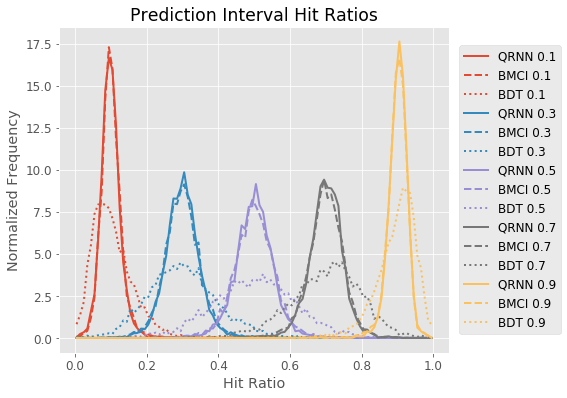

In [24]:
quantiles = ["0.1", "0.3", "0.5", "0.7", "0.9"]

model_q = load_model("model_q_5.h5", custom_objects={"<lambda>":"mean_absolute_error"})
model_q_2 = load_model("model_q_10_384.h5", custom_objects={"<lambda>":"mean_absolute_error"})
y_pred_bmci = np.load("y_pred_bmci_5.npy")
y_pred_bdt = np.load("y_pred_qrbdt.npy")

def compare_bmci(model, x_test, cwv):
    x_test = (x_test - x_mean) / x_sigma
#    y_pred = model_q.predict(x_test)
    y_pred = model_q_2.predict(x_test)
#    y_pred = 0.5 * y_pred_all[:,[0,2,5,7,9]]
#    y_pred += 0.5 * y_pred_all[:,[1,3,5,8,10]]
    
    plt.figure(figsize=(10,6))
    
    ratios = np.zeros((cwv.shape[0], 5))
    bins   = np.linspace(0,1,101)
    x = 0.5 * (bins[1:] + bins[:-1])
    
    for j in range(5):
        t = y_pred[:,j]
        hits = (cwv < t.reshape(-1,1))
        ratios[:,j] = (hits.sum(axis=1, keepdims=True) / hits.shape[1]).ravel()
        y, _ = np.histogram(ratios[:,j], bins=bins, normed=True)
        plt.plot(x, y,  c="C{}".format(j), label="QRNN " + quantiles[j], lw=2)
        
        t = y_pred_bmci[:,j]
        hits = (cwv < t.reshape(-1,1))
        ratios[:,j] = (hits.sum(axis=1, keepdims=True) / hits.shape[1]).ravel()
        y, _ = np.histogram(ratios[:,j], bins=bins, normed=True)
        plt.plot(x, y, c="C{}".format(j), label = "BMCI " + str(quantiles[j]), ls="--", lw=2)
        
        t = y_pred_bdt[:,j]
        hits = (cwv < t.reshape(-1,1))
        ratios[:,j] = (hits.sum(axis=1, keepdims=True) / hits.shape[1]).ravel()
        y, _ = np.histogram(ratios[:,j], bins=bins, normed=True)
        plt.plot(x, y, c="C{}".format(j), label = "BDT " + str(quantiles[j]), ls=":", lw=2)
        
    box = plt.gca().get_position()
    plt.gca().set_position([box.x0, box.y0, box.width * 0.7, box.height])
    plt.gca().legend(loc="center right", bbox_to_anchor=[1.3, 0.5])
    
    return y_pred


import matplotlib
matplotlib.rcParams["figure.figsize"] = (8,6)
ratios = compare_bmci(model_opt, v_y_true, v_cwv)
plt.title("Prediction Interval Hit Ratios")
plt.xlabel("Hit Ratio")
plt.ylabel("Normalized Frequency")

np.mean(ratios, axis=0)

In [15]:
ratios.shape

(5000, 11)

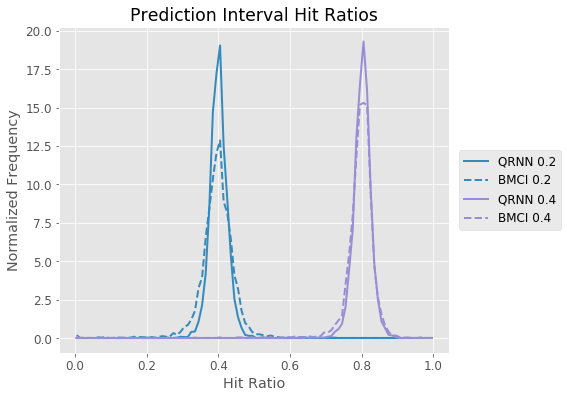

In [25]:
intervals = ["0.0", "0.2", "0.4"]

y_pred_bmci = np.load("y_pred_bmci_5.npy")

def compare_bmci(model, x_test, cwv):
    x_test = (x_test - x_mean) / x_sigma
    y_pred = model.predict(x_test)
    
    plt.figure(figsize=(10,6))
    
    ratios = np.zeros((cwv.shape[0], 5))
    bins   = np.linspace(0,1,101)
    x = 0.5 * (bins[1:] + bins[:-1])
    
    for j in range(1,3):
        
        t_l = y_pred[:,2-j]
        t_r = y_pred[:,2+j]
        hits = (cwv > t_l.reshape(-1,1)) * (cwv < t_r.reshape(-1,1))
        ratios[:,j] = (hits.sum(axis=1, keepdims=True) / hits.shape[1]).ravel()
        y, _ = np.histogram(ratios[:,j], bins=bins, normed=True)
        plt.plot(x, y,  c="C{}".format(j), label="QRNN " + intervals[j], lw=2)
        
        t_l = y_pred_bmci[:,2-j]
        t_r = y_pred_bmci[:,2+j]
        hits = (cwv > t_l.reshape(-1,1)) * (cwv < t_r.reshape(-1,1))
        ratios[:,j] = (hits.sum(axis=1, keepdims=True) / hits.shape[1]).ravel()
        y, _ = np.histogram(ratios[:,j], bins=bins, normed=True)
        plt.plot(x, y, c="C{}".format(j), label = "BMCI " + str(intervals[j]), ls="--", lw=2)
        
    box = plt.gca().get_position()
    plt.gca().set_position([box.x0, box.y0, box.width * 0.7, box.height])
    plt.gca().legend(loc="center right", bbox_to_anchor=[1.3, 0.5])
    
    return ratios


import matplotlib
matplotlib.rcParams["figure.figsize"] = (8,6)
ratios = compare_bmci(model_q_2, v_y_true, v_cwv)
plt.title("Prediction Interval Hit Ratios")
plt.xlabel("Hit Ratio")
plt.ylabel("Normalized Frequency")



CPU times: user 1.72 s, sys: 568 ms, total: 2.29 s
Wall time: 13 s


[array([[ 0.0991252,  0.2982032,  0.4982292,  0.6995066,  0.9004312]])]

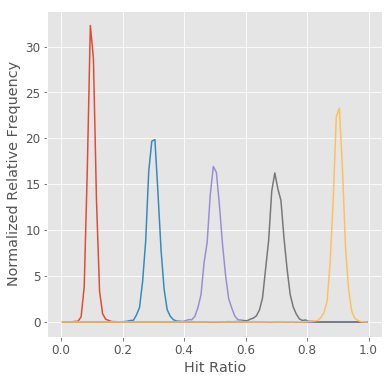

In [21]:

labels = ["0.1", "0.3", "0.5", "0.7", "0.9"]

y_pred_bmci = np.load("y_pred_bmci.npy")

def interval_errors(models, y, cwv):
    plt.figure()
    y_test = (y - x_mean) / x_sigma
    model_ratios = []
    for i,m in enumerate(models):
        x_pred = m.predict(y_test)
        ratios = np.zeros((cwv.shape[0], 5))
        bins   = np.linspace(0,1,101)
        x = 0.5 * (bins[1:] + bins[:-1])
        for j in range(5):
            t_l = x_pred[:,4-j]
            t_r = x_pred[:,6+j]
            hits = (cwv > t_l.reshape(-1,1)) * (cwv < t_r.reshape(-1,1))
            ratios[:,j] = (hits.sum(axis=1, keepdims=True) / hits.shape[1]).ravel()
            y, _ = np.histogram(ratios[:,j], bins=bins, normed=True)
            plt.plot(x, y, label=labels[j], c="C{}".format(j), alpha=1.0*(i+1))
        model_ratios += [ratios.mean(axis=0, keepdims=True)]
    return model_ratios


%time errs = interval_errors([model_3_128], v_y_true, v_cwv)
plt.xlabel("Hit Ratio")
plt.ylabel("Normalized Relative Frequency")

errs

In [ ]:
bins = np.logspace(np.log10(np.min(v_cwv_true)), np.log10(np.max(v_cwv_true)), 41)     plt.hist(v_cwv_true, bins=bins) plt.xscale("log") plt.xlabel("CWV $[kg/m^2]$")
plt.ylabel("Frequency of Occurence")
np.mean(v_cwv_true)

In [ ]:
for i in range(100):
    plt.plot(v_h2o[0,i,:], alpha=0.01, color="b")

In [ ]:
from mcmc_retrievals import covmat_x
plt.imshow(covmat_x)
plt.colorbar()

In [49]:
model.loss

'mean_absolute_error'